In [1]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from torch.utils.data import DataLoader, TensorDataset

from pytorch_helpers import MLP
from sklearn_helpers import (
    get_column_transformer,
    get_preprocessor,
    print_metrics,
    show_coefficients,
)

simplefilter(action="ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")
pd.set_option("precision", 3)


In [2]:
# SECTION: Analyze Performance on Validation Set during Training
k_best_results = pd.read_pickle("k_best_results.pkl")
rfe_results = pd.read_pickle("rfe_results.pkl")
vt_results = pd.read_pickle("vt_results.pkl")
pca_results = pd.read_pickle("pca_results.pkl")
full_features_results = pd.read_pickle("full_features_results.pkl")
neural_network_results = pd.read_pickle("neural_network_results.pkl")

complete_results = pd.concat(
    [
        k_best_results,
        rfe_results,
        vt_results,
        pca_results,
        full_features_results,
        neural_network_results,
    ]
).sort_values("mae_val")

complete_results.to_pickle("complete_results.pkl")


In [3]:
# SUBSECTION: Analyze Results
complete_results


,mae_train,mae_val,r2_train,r2_val,mse_train,mse_val,hyperparam_keys,hyperparam_values,num_features,feature_selector,log_y
NeuralNetwork,596.024,391.825,0.200,0.207,1.369e+06,9.060e+05,"[batch_size, num_epochs, learning_rate, dropou...","[128, 200, 0.01, 0.5]",40.0,None,False
LinearRegression,419.894,426.236,0.243,0.324,1.213e+06,1.230e+06,None,None,30.0,RFE,True
LinearRegression,421.754,426.888,0.240,0.326,1.218e+06,1.233e+06,None,None,20.0,RFE,True
Ridge,420.799,427.039,0.240,0.322,1.217e+06,1.234e+06,alpha,10,30.0,RFE,True
LinearRegression,419.771,427.680,0.244,0.324,1.210e+06,1.232e+06,None,None,40.0,None,True
...,...,...,...,...,...,...,...,...,...,...,...
Lasso,578.262,578.700,-0.038,-0.048,1.658e+06,1.660e+06,alpha,14,30.0,RFE,True
Lasso,578.262,578.700,-0.038,-0.048,1.658e+06,1.660e+06,alpha,14,10.0,PCA,True
Lasso,578.262,578.700,-0.038,-0.048,1.658e+06,1.660e+06,alpha,14,40.0,None,True
Lasso,578.262,578.700,-0.038,-0.048,1.658e+06,1.660e+06,alpha,14,30.0,PCA,True


In [4]:
# Baseline Performance
complete_results.loc["Mean Prediction"]

,mae_train,mae_val,r2_train,r2_val,mse_train,mse_val,hyperparam_keys,hyperparam_values,num_features,feature_selector,log_y
Mean Prediction,578.287,578.287,-0.038,-0.038,1.658e+06,1.658e+06,None,None,NaN,None,True
Mean Prediction,643.527,643.527,0.000,0.000,1.598e+06,1.598e+06,None,None,NaN,None,False


In [5]:
complete_results.sort_values("r2_val", ascending=False)


,mae_train,mae_val,r2_train,r2_val,mse_train,mse_val,hyperparam_keys,hyperparam_values,num_features,feature_selector,log_y
LinearRegression,421.754,426.888,0.240,0.326,1.218e+06,1.233e+06,None,None,20.0,RFE,True
LinearRegression,419.894,426.236,0.243,0.324,1.213e+06,1.230e+06,None,None,30.0,RFE,True
LinearRegression,419.771,427.680,0.244,0.324,1.210e+06,1.232e+06,None,None,40.0,None,True
Ridge,422.657,427.683,0.237,0.324,1.222e+06,1.236e+06,alpha,10,20.0,RFE,True
Ridge,420.542,427.756,0.242,0.322,1.214e+06,1.234e+06,alpha,10,40.0,None,True
...,...,...,...,...,...,...,...,...,...,...,...
Lasso,578.262,578.700,-0.038,-0.048,1.658e+06,1.660e+06,alpha,14,30.0,RFE,True
Lasso,578.262,578.700,-0.038,-0.048,1.658e+06,1.660e+06,alpha,14,10.0,PCA,True
Lasso,578.262,578.700,-0.038,-0.048,1.658e+06,1.660e+06,alpha,14,40.0,None,True
Lasso,578.262,578.700,-0.038,-0.048,1.658e+06,1.660e+06,alpha,14,30.0,PCA,True


In [6]:
# stratified by log_y
complete_results.groupby("log_y").apply(lambda x: x.nsmallest(3, "mae_val"))


mae_train  mae_val  r2_train  r2_val  mse_train  \
log_y                                                                          
False NeuralNetwork            596.024  391.825     0.200   0.207  1.369e+06   
      RandomForestRegressor    452.886  481.355     0.332   0.238  1.070e+06   
      RandomForestRegressor    453.250  482.045     0.343   0.257  1.051e+06   
True  LinearRegression         419.894  426.236     0.243   0.324  1.213e+06   
      LinearRegression         421.754  426.888     0.240   0.326  1.218e+06   
      Ridge                    420.799  427.039     0.240   0.322  1.217e+06   

                               mse_val  \
log_y                                    
False NeuralNetwork          9.060e+05   
      RandomForestRegressor  1.270e+06   
      RandomForestRegressor  1.243e+06   
True  LinearRegression       1.230e+06   
      LinearRegression       1.233e+06   
      Ridge                  1.234e+06   

                                                               hyperparam_keys  \
log_y                                                                            
False NeuralNetwork          [batch_size, num_epochs, learning_rate, dropou...   
      RandomForestRegressor        [n_estimators, min_samples_leaf, max_depth]   
      RandomForestRegressor        [n_estimators, min_samples_leaf, max_depth]   
True  LinearRegression                                                    None   
      LinearRegression                                                    None   
      Ridge                                                              alpha   

                                 hyperparam_values  num_features  \
log_y                                                              
False NeuralNetwork          [128, 200, 0.01, 0.5]          40.0   
      RandomForestRegressor              [6, 7, 4]          10.0   
      RandomForestRegressor              [6, 7, 4]          20.0   
True  LinearRegression                        None          30.0   
      LinearRegression                        None          20.0   
      Ridge                                     10          30.0   

                            feature_selector  log_y  
log_y                                                
False NeuralNetwork                     None  False  
      RandomForestRegressor              RFE  False  
      RandomForestRegressor              RFE  False  
True  LinearRegression                   RFE   True  
      LinearRegression                   RFE   True  
      Ridge                              RFE   True

In [7]:
complete_results.groupby("log_y").apply(lambda x: x.nlargest(3, "r2_val"))


mae_train  mae_val  r2_train  r2_val  mse_train  \
log_y                                                                     
False LinearRegression    496.836  502.903     0.246   0.290  1.207e+06   
      Ridge               487.660  491.645     0.227   0.287  1.237e+06   
      Lasso               489.892  494.011     0.230   0.285  1.232e+06   
True  LinearRegression    421.754  426.888     0.240   0.326  1.218e+06   
      LinearRegression    419.894  426.236     0.243   0.324  1.213e+06   
      LinearRegression    419.771  427.680     0.244   0.324  1.210e+06   

                          mse_val hyperparam_keys hyperparam_values  \
log_y                                                                 
False LinearRegression  1.239e+06            None              None   
      Ridge             1.259e+06           alpha               430   
      Lasso             1.257e+06           alpha                20   
True  LinearRegression  1.233e+06            None              None   
      LinearRegression  1.230e+06            None              None   
      LinearRegression  1.232e+06            None              None   

                        num_features feature_selector  log_y  
log_y                                                         
False LinearRegression          20.0              RFE  False  
      Ridge                     20.0              RFE  False  
      Lasso                     20.0              RFE  False  
True  LinearRegression          20.0              RFE   True  
      LinearRegression          30.0              RFE   True  
      LinearRegression          40.0             None   True

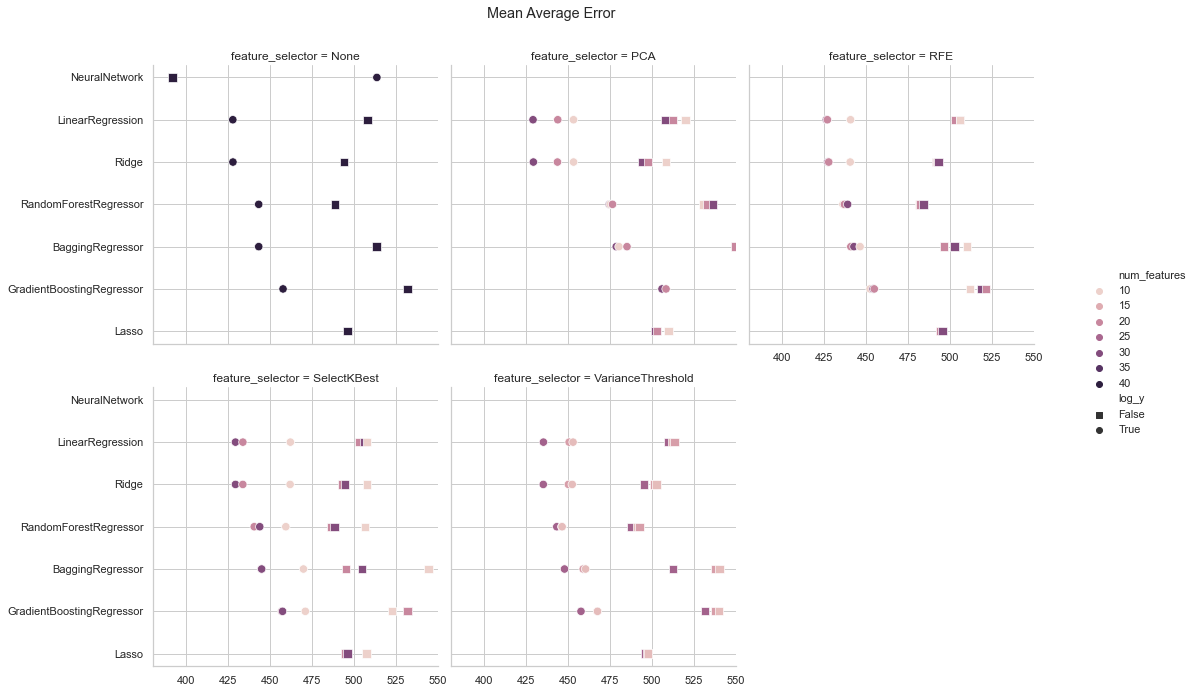

In [8]:
plot_data = complete_results.fillna({"feature_selector": "None"}).astype(
    {"feature_selector": "category"}
)[["mae_val", "r2_val", "num_features", "feature_selector", "log_y"]]

g = sns.relplot(
    data=plot_data,
    x="mae_val",
    y=plot_data.index,
    hue="num_features",
    col="feature_selector",
    col_wrap=3,
    style="log_y",
    markers=["s", "o"],
    s=70,
).set(xlabel="", ylabel="", xlim=(380, 550))

g.fig.suptitle("Mean Average Error")
g.fig.subplots_adjust(top=0.9)

sns.move_legend(obj=g, loc="center", bbox_to_anchor=(1, 0.5), frameon=False)


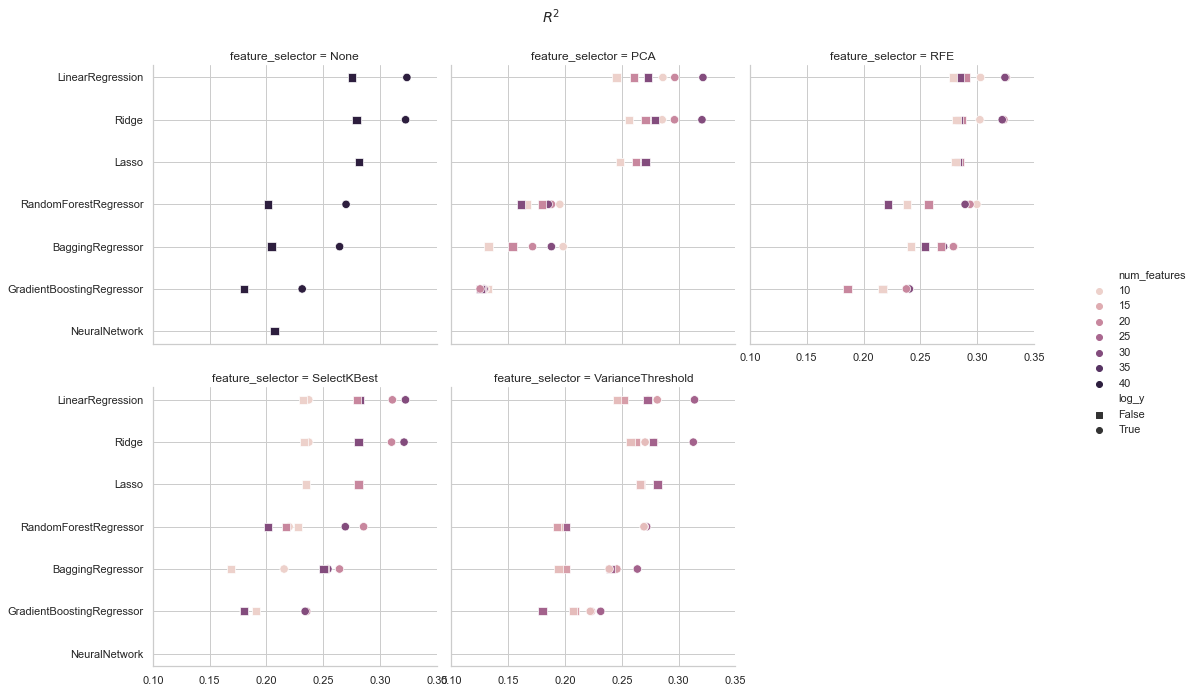

In [9]:
plot_data = plot_data.sort_values("r2_val", ascending=False)

g = sns.relplot(
    data=plot_data,
    x="r2_val",
    y=plot_data.index,
    hue="num_features",
    col="feature_selector",
    col_wrap=3,
    style="log_y",
    markers=["s", "o"],
    s=70,
).set(xlabel="", ylabel="", xlim=(0.1, 0.35))

g.fig.suptitle(r"$R^2$")
g.fig.subplots_adjust(top=0.9)

sns.move_legend(obj=g, loc="center", bbox_to_anchor=(1, 0.5), frameon=False)


In [10]:
# SECTION: Evaluate Performance of Best Models on Test Set
X_train_val = pd.read_pickle("../data-clean/X_train_val.pkl")
y_train_val = pd.read_pickle("../data-clean/y_train_val.pkl")

X_test = pd.read_pickle("../data-clean/X_test.pkl")
y_test = pd.read_pickle("../data-clean/y_test.pkl")


In [11]:
# SUBSECTION: Classical Model with lowest MAE on Validation Set
column_transformer = get_column_transformer()
rfe = RFE(SVR(kernel="linear"), n_features_to_select=30, step=0.5)
preprocessor = get_preprocessor(column_transformer, rfe)

best_model_mae = LinearRegression()
pipeline = make_pipeline(preprocessor, best_model_mae)
log_transform = TransformedTargetRegressor(pipeline, func=np.log, inverse_func=np.exp)

log_transform.fit(X_train_val, y_train_val)
y_hat_mae = log_transform.predict(X_test)

print_metrics(y_test, y_hat_mae)
coefs_30 = show_coefficients(log_transform)
coefs_30


MAE: 401.450
R^2: 0.162


,feature,coefficient
0,neighbourhood_Sentrum,0.378
1,bedrooms,0.270
2,neighbourhood_Frogner,0.268
3,room_type_Entire home/apt,0.261
4,neighbourhood_Gamle Oslo,0.154
5,neighbourhood_St. Hanshaugen,0.141
6,neighbourhood_Grünerløkka,0.133
7,availability_365,0.124
8,neighbourhood_Nordstrand,0.052
9,number_bathrooms,0.037


In [12]:
# SUBSECTION: Classical Model with lowest R^2 on Validation Set
rfe = RFE(SVR(kernel="linear"), n_features_to_select=20, step=0.5)
preprocessor = get_preprocessor(column_transformer, rfe)

best_model_r2 = LinearRegression()
pipeline = make_pipeline(preprocessor, best_model_r2)
log_transform = TransformedTargetRegressor(pipeline, func=np.log, inverse_func=np.exp)

log_transform.fit(X_train_val, y_train_val)
y_hat_r2 = log_transform.predict(X_test)

print_metrics(y_test, y_hat_r2)
show_coefficients(log_transform)


MAE: 405.692
R^2: 0.157


,feature,coefficient
0,neighbourhood_Sentrum,0.356
1,room_type_Entire home/apt,0.316
2,bedrooms,0.294
3,neighbourhood_Frogner,0.266
4,neighbourhood_Gamle Oslo,0.151
5,neighbourhood_St. Hanshaugen,0.148
6,neighbourhood_Grünerløkka,0.128
7,availability_365,0.124
8,neighbourhood_Nordstrand,0.057
9,neighbourhood_Vestre Aker,0.047


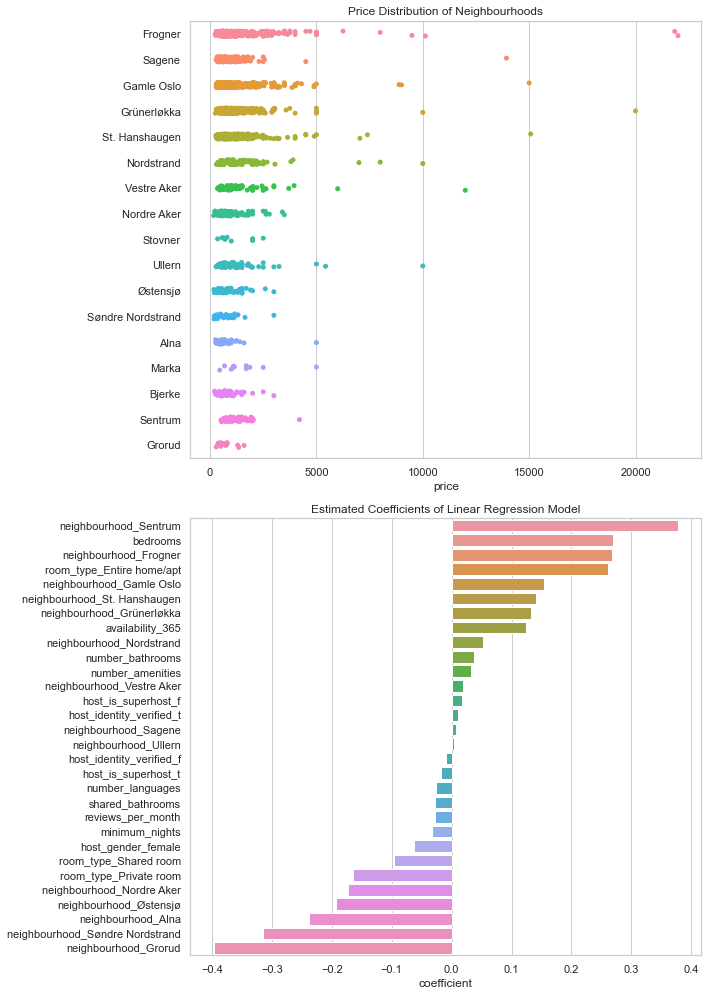

In [13]:
# Neighbourhood has the strongest influence
listings_df = pd.read_pickle("../data-clean/listings_subset.pkl")

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 14))

sns.stripplot(data=listings_df, x="price", y="neighbourhood", ax=ax1).set(
    title="Price Distribution of Neighbourhoods", ylabel=""
)

sns.barplot(data=coefs_30, x="coefficient", y="feature", ax=ax2).set(
    title="Estimated Coefficients of Linear Regression Model", ylabel=""
)

fig.tight_layout()
plt.show()


In [14]:
# SUBSECTION: Neural Network Model
column_transformer = get_column_transformer()
column_transformer.fit(X_train_val)

X_tensor_test = torch.tensor(column_transformer.transform(X_test).astype(np.float32))
y_tensor_test = torch.tensor(y_test.values.astype(np.float32))
testset = TensorDataset(X_tensor_test, y_tensor_test)
testloader = DataLoader(testset, batch_size=X_tensor_test.shape[0])

in_features = X_tensor_test.shape[1]
hidden_features_list = [64, 128, 256, 512, 512, 256, 128, 64, 32, 16, 8]
dropout_prob = 0.5

model = MLP(in_features, hidden_features_list, dropout_prob)
model.load_state_dict(torch.load("fully_connected_weights.pt"))
model.eval()

with torch.no_grad():
    X_nn, y_nn = next(iter(testloader))
    y_hat_nn = model(X_nn).squeeze()

print_metrics(y_test, y_hat_nn.detach())


MAE: 412.340
R^2: 0.121


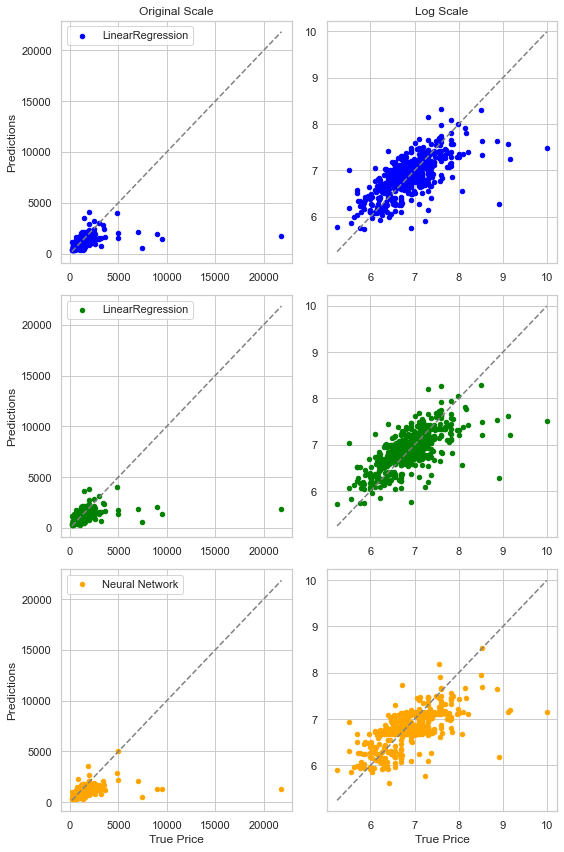

In [15]:
# SUBSECTION: Plot Predictions vs. True Price
best_model_mae_name = best_model_mae.__class__.__name__
best_model_r2_name = best_model_r2.__class__.__name__
size = 20

range_original = [min(y_test), max(y_test)]
range_log = [min(np.log(y_test)), max(np.log(y_test))]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flat

# identity line
ax1.scatter(
    y_test.values, y_hat_mae, label=f"{best_model_mae_name}", s=size, color="blue"
)

ax2.scatter(
    np.log(y_test.values),
    np.log(y_hat_mae),
    label=f"{best_model_mae_name}",
    s=size,
    color="blue",
)

ax3.scatter(
    y_test.values, y_hat_r2, label=f"{best_model_r2_name}", s=size, color="green"
)

ax4.scatter(
    np.log(y_test.values),
    np.log(y_hat_r2),
    label=f"{best_model_r2_name}",
    s=size,
    color="green",
)

ax5.scatter(y_test.values, y_hat_nn, label="Neural Network", s=size, color="orange")

ax6.scatter(
    np.log(y_test.values),
    np.log(y_hat_nn),
    label="Neural Network",
    s=size,
    color="orange",
)

for index, ax in enumerate(axes.flat):
    if index % 2 == 0:
        ax.set(ylabel="Predictions")
        ax.legend()
        # identity line
        ax.plot(range_original, range_original, linestyle="dashed", color="grey")
    else:
        ax.plot(range_log, range_log, linestyle="dashed", color="grey")
    if index == 0:
        ax.set(title="Original Scale")
    if index == 1:
        ax.set(title="Log Scale")
    if index in (4, 5):
        ax.set(xlabel="True Price")

fig.tight_layout()
plt.show()
